## 1. Тест Вильямса

In [108]:
import pandas as pd
import numpy
from matplotlib import pyplot as plt
from scipy import integrate, linalg

MainFoil = pd.read_csv('lessons/resources/MainFoil_N=200.csv')

MainFoil_x = MainFoil['1.000000000000000000e+00'].to_numpy(copy=True)
MainFoil_y = MainFoil['5.900000000000000730e-03'].to_numpy(copy=True)

MainFoil_x = numpy.insert(MainFoil_x, 0, 1.0)
MainFoil_y = numpy.insert(MainFoil_y, 0, 5.90000000000000073e-03)

print()

In [109]:
FlapFoil = pd.read_csv('lessons/resources/FlapFoil_N=200.csv')

FlapFoil_x = FlapFoil['1.313890000000000002e+00'].to_numpy(copy=True)
FlapFoil_y = FlapFoil['-2.036300000000004495e-01'].to_numpy(copy=True)

FlapFoil_x = numpy.insert(FlapFoil_x, 0, 1.313890000000000002e+00)
FlapFoil_y = numpy.insert(FlapFoil_y, 0, -2.036300000000004495e-01)

print()

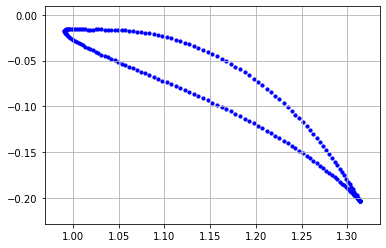

In [110]:
plt.scatter(MainFoil_x, MainFoil_y, color='g', s=10)
plt.scatter(FlapFoil_x, FlapFoil_y, color='b', s=10)
plt.axis("equal")
plt.grid()

In [111]:
class Panel:

    def __init__(self, xa, ya, xb, yb):

        self.xa, self.ya = xa, ya # начальная точка панели
        self.xb, self.yb = xb, yb # конечная точка панели
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # центр панели
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # длина панели
        
        # ориентация панели (угол между нормалью и осью x)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # расположение панели
        if self.beta <= numpy.pi:
            self.loc = 'upper' # верхняя поверхность
        else:
            self.loc = 'lower' # нижняя поверхность
        
        self.sigma = 0.0 # интенсивность источника
        self.vt = 0.0    # касательная скорость
        self.cp = 0.0    # коэффициент давления

In [112]:
def define_panels(x, y):

    panels = numpy.empty(len(x)-1, dtype=object)
    for i in range(len(x)-1):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    
    return panels

In [113]:
MainFoil_panels = define_panels(MainFoil_x, MainFoil_y)
FlapFoil_panels = define_panels(FlapFoil_x, FlapFoil_y)

In [114]:
class Freestream:

    def __init__(self, u_inf=1.0, alpha=0.0):

        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # градусы в радианы

In [115]:
alpha = 0.0
u_inf = 1.0
freestream = Freestream(u_inf, alpha)

In [116]:
def integral(x, y, panel, dxdk, dydk):

    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [117]:
def source_contribution_normal(panels):

    A = numpy.empty((panels.size, panels.size), dtype=float)

    numpy.fill_diagonal(A, 0.5)

    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [118]:
def vortex_contribution_normal(panels):

    A = numpy.empty((panels.size, panels.size), dtype=float)

    numpy.fill_diagonal(A, 0.0)

    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [119]:
panels = numpy.concatenate((MainFoil_panels, FlapFoil_panels))

(-0.3, 0.3)

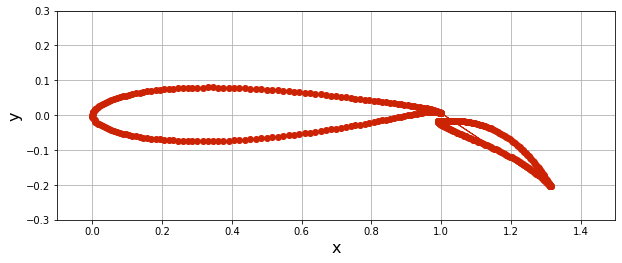

In [120]:
width = 10
plt.figure(figsize=(width, width))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, \
            color='#CD2305')
plt.axis('scaled', adjustable='box')
plt.xlim(-0.1, 1.5)
plt.ylim(-0.3, 0.3)

In [30]:
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

In [31]:
def kutta_condition(A_source, B_vortex, Na):

    b2 = numpy.empty(A_source.shape[0]+2, dtype=float)
    b1 = numpy.empty(A_source.shape[0]+2, dtype=float)
    
    b1[:-2] = B_vortex[0, :] + B_vortex[Na-1, :]
    b1[-2] = - numpy.sum(A_source[0, :Na] + A_source[Na-1, :Na])
    b1[-1] = - numpy.sum(A_source[0, Na:] + A_source[Na-1, Na:])
    
    b2[:-2] = B_vortex[Na, :] + B_vortex[-1, :]
    b2[-2] = - numpy.sum(A_source[Na, :Na] + A_source[-1, :Na])
    b2[-1] = - numpy.sum(A_source[Na, Na:] + A_source[-1, Na:])
    

    return b1, b2

In [32]:
def build_singularity_matrix(A_source, B_vortex, Na):

    A = numpy.empty((A_source.shape[0]+2, A_source.shape[1]+2), \
                    dtype=float)

    A[:-2, :-2] = A_source

    A[:-2, -2] = numpy.sum(B_vortex[:,0:Na], axis=1)
    A[:-2, -1] = numpy.sum(B_vortex[:,Na:], axis=1)
    
    A[-2, :], A[-1, :] = kutta_condition(A_source, B_vortex, numpy.size(MainFoil_panels))
    return A

In [33]:
a = numpy.empty((2, 3))
a

array([[ 58.55517074, 104.53703515, 150.51889957],
       [196.50076399, 242.4826284 , 241.64      ]])

In [34]:
def build_freestream_rhs(panels, freestream, Na):

    b = numpy.empty(panels.size+2,dtype=float)

    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)

        b[-1] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                               +numpy.sin(freestream.alpha-panels[Na-1].beta) )
        b[-2] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[Na].beta)
                               +numpy.sin(freestream.alpha-panels[-1].beta) )
    return b

In [35]:
A = build_singularity_matrix(A_source, B_vortex, numpy.size(MainFoil_panels))
b = build_freestream_rhs(panels, freestream, numpy.size(MainFoil_panels))

In [36]:
# рассчитываем интенсивности источников и вихря
strengths = numpy.linalg.solve(A, b)

# заполняем интенсивности на кажой панели
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
    
# запоминаем циркуляцию
gamma1 = strengths[-2]
gamma2 = strengths[-1]

In [37]:
def get_velocity_field(panels, freestream, X, Y):

    u = freestream.u_inf * numpy.cos(freestream.alpha) *\
    numpy.ones_like(X, dtype=float)
    v = freestream.u_inf * numpy.sin(freestream.alpha) *\
    numpy.ones_like(X, dtype=float)

    vec_intregral = numpy.vectorize(integral)
    
    for panel in panels:
        u += panel.sigma / (2.0 * numpy.pi) * \
        vec_intregral(X, Y, panel, 1, 0) - gamma1 / (2.0 * numpy.pi) * vec_intregral(X, Y, panel, 0, -1)
        v += panel.sigma / (2.0 * numpy.pi) * \
        vec_intregral(X, Y, panel, 0, 1) - gamma1 / (2.0 * numpy.pi) * vec_intregral(X, Y, panel, 1, 0)
        u += panel.sigma / (2.0 * numpy.pi) * \
        vec_intregral(X, Y, panel, 1, 0) - gamma2 / (2.0 * numpy.pi) * vec_intregral(X, Y, panel, 0, -1)
        v += panel.sigma / (2.0 * numpy.pi) * \
        vec_intregral(X, Y, panel, 0, 1) - gamma2 / (2.0 * numpy.pi) * vec_intregral(X, Y, panel, 1, 0)
    
    return u, v

In [38]:
nx, ny = 10, 10
x_start, x_end = -0.5, 2.0
y_start, y_end = -0.5, 0.5
X, Y = numpy.meshgrid(numpy.linspace(x_start, x_end, nx),
                      numpy.linspace(y_start, y_end, ny))

u, v = get_velocity_field(panels, freestream, X, Y)

(-0.5, 0.5)

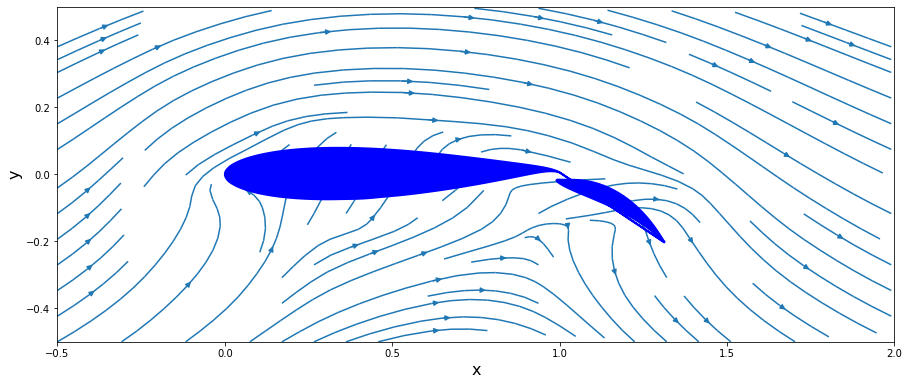

In [39]:
# рисуем поле скорости
width = 15
plt.figure(figsize=(width, width))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.streamplot(X, Y, u, v)
plt.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='b', linestyle='solid', linewidth=2, zorder=2)
plt.axis('scaled', adjustable='box')
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)

In [40]:
def compute_tangential_velocity(panels, freestream, gamma1, gamma2, A_source, B_vortex, Na):

    A = numpy.empty((panels.size, panels.size+2), dtype=float)
    # матрица вкладов источников в тангенциальную составляющую скорости
    # равна
    # матрице вкладов вихрей в нормальную составляющую скорости
    A[:, :-2] = B_vortex
    # матрица вкладов вихрей в тангенциальную составляющую скорости
    # противоположна по знаку
    # матрице вкладов источников в нормальную составляющую скорости
    A[:, -2] = -numpy.sum(A_source[:, :Na], axis=1)
    A[:, -1] = -numpy.sum(A_source[:, Na:], axis=1)
    # добавляем набегающий поток
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], [gamma1, gamma2])
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [41]:
compute_tangential_velocity(panels, freestream, gamma1, gamma2, A_source, B_vortex, numpy.size(MainFoil_panels))

In [42]:
def compute_pressure_coefficient(panels, freestream):

    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [43]:
# коэффициент давления на поверхности
compute_pressure_coefficient(panels, freestream)

In [44]:
Cp_Flap = pd.read_csv('lessons/resources/Cp_Flap_theoretical.csv')
Cp_Main = pd.read_csv('lessons/resources/Cp_Main_theoretical.csv')

Cp_Flap_x = Cp_Flap['1.313890000000000002e+00'].to_numpy(copy=True)
Cp_Flap_y = Cp_Flap['1.000000000000000000e+00'].to_numpy(copy=True)

Cp_Flap_x = numpy.insert(Cp_Flap_x, 0, 1.313890000000000002e+00)
Cp_Flap_y = numpy.insert(Cp_Flap_y, 0, 1.0)

Cp_Main_x = Cp_Main['1.000000000000000000e+00'].to_numpy(copy=True)
Cp_Main_y = Cp_Main['1.000000000000000000e+00.1'].to_numpy(copy=True)

Cp_Main_x = numpy.insert(Cp_Main_x, 0, 1.0)
Cp_Main_y = numpy.insert(Cp_Main_y, 0, 1.0)

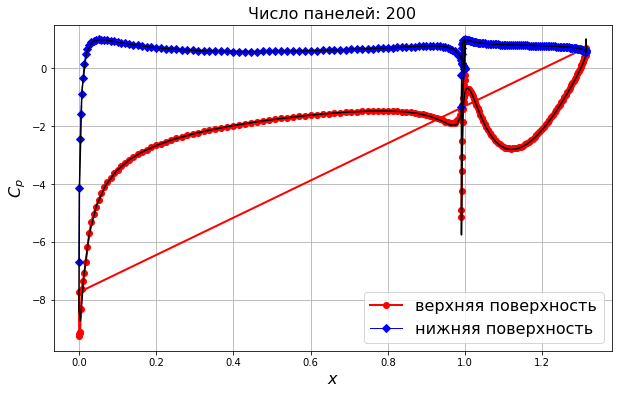

In [46]:
# рисуем коэффициент давления на поверхности
from matplotlib import pyplot
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='верхняя поверхность',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'нижняя поверхность',
            color='b', linestyle='-', linewidth=1, marker='D', markersize=6)
pyplot.legend(loc='best', prop={'size':16})

pyplot.plot(Cp_Main_x, Cp_Main_y, color='k')
pyplot.plot(Cp_Flap_x, Cp_Flap_y, color='k')

pyplot.title('Число панелей: {}'.format(numpy.size(MainFoil_panels)), fontsize=16);

In [47]:
Na = numpy.size(MainFoil_panels)

### Вопросы:

In [48]:
print("Коэффициент давления на 3 панели:", panels[3].cp)

Коэффициент давления на 3 панели: -0.8052080457109694


In [49]:
print("Коэффициент давления на 10 панели закрылка:", panels[Na+10].cp)

Коэффициент давления на 10 панели закрылка: 0.21480022226339968


In [50]:
Cl = 0

for i , panel in enumerate(panels):
    if panel.loc == 'upper':
        if i < Na:
            Cl += abs(panel.cp - panels[Na-i].cp)*(panel.xa-panel.xb)
        else:
            Cl += abs(panel.cp - panels[panels.size-i].cp)*(panel.xa-panel.xb)
print('Коэффициент подъемной силы: CL = {:0.3f}'.format(Cl))

Коэффициент подъемной силы: CL = 3.673
